In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

100%|██████████| 14.5M/14.5M [00:42<00:00, 360kB/s]

Extracting files...


Path to dataset files: C:\Users\KNPRO\.cache\kagglehub\datasets\mashlyn\online-retail-ii-uci\versions\3


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly for interactive visualizations
import plotly.express as px

# Scikit-learn modules for clustering and preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Display settings for better readability
pd.options.display.float_format = '{:,.2f}'.format  # comma for thousands separator
pd.set_option('display.max_columns', None)         

df=pd.read_csv("online_retail_II.csv")

In [10]:
df.describe()

df.info()

# Generate descriptive statistics for numeric and categorical columns
df.describe()
df.describe(include='O')

# Display the first 10 rows where Customer ID is missing 
df[df["Customer ID"].isna()].head(10) 

# Display the first 10 rows where Quantity is negative (likely returns or cancellations)
df[df["Quantity"] < 0].head(10)

# Display the first 10 rows for a quick look at the dataset
df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,"13,085.00",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,"13,085.00",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,"13,085.00",United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,"13,085.00",United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,"13,085.00",United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,"13,085.00",United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,"13,085.00",United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,"13,085.00",United Kingdom


In [11]:
df["Invoice"] = df["Invoice"].astype(str)

# Filter invoices that do not match exactly 6-digit numeric format
df[~df["Invoice"].str.match(r"^\d{6}$")] 

# Extract and display unique non-numeric prefixes from the Invoice column
df["Invoice"].str.replace(r"[0-9]", "", regex=True).unique()

# Filter rows where Invoice starts with 'A' (could indicate special invoice type)
df[df["Invoice"].str.startswith("A")]

# Ensure StockCode is treated as string for regex operations
df["StockCode"] = df["StockCode"].astype(str)

# Find StockCodes that do NOT match either:
# - Exactly 5 digits (e.g., '12345')
# - 5 digits followed by letters (e.g., '12345AB')
invalid_stockcodes = df[
    (~df["StockCode"].str.match(r"^\d{5}$")) & 
    (~df["StockCode"].str.match(r"^\d{5}[a-zA-Z]+$"))
]["StockCode"].unique()
invalid_stockcodes

# Filter rows where StockCode contains 'DOT' at the start (e.g., promotional or special codes)
df[df["StockCode"].str.startswith("DOT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1062295,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,"1,008.96",NaN,United Kingdom
1062715,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,"1,683.75",NaN,United Kingdom
1064829,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,NaN,United Kingdom
1066369,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,NaN,United Kingdom


In [12]:
cleaned_df = df.copy()

# Convert Invoice to string (to ensure consistent filtering)
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype(str)

# Keep only invoices that are exactly 6 digits (standard invoices)
mask = cleaned_df["Invoice"].str.match(r"^\d{6}$") == True
cleaned_df = cleaned_df[mask]

# Convert StockCode to string and apply filtering rules
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype(str)
mask = (
    cleaned_df["StockCode"].str.match(r"^\d{5}$") |
    cleaned_df["StockCode"].str.match(r"^\d{5}[a-zA-Z]+$") |
    (cleaned_df["StockCode"] == "PADS")
)
cleaned_df = cleaned_df[mask]

# Drop rows where 'Customer ID' is missing, as these entries lack customer info
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

In [13]:
cleaned_df.describe()

# Count how many rows have zero price (potentially free items or errors)
len(cleaned_df[cleaned_df["Price"] == 0])

# Filter out rows where Price is zero or less (invalid or free items)
cleaned_df = cleaned_df[cleaned_df["Price"] > 0.0]

# Show summary statistics after filtering out zero or negative prices
cleaned_df.describe()

# Find minimum price in the cleaned dataset
cleaned_df["Price"].min()

0.001

In [14]:
# Calculate total sales amount per transaction line
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]

# Display updated DataFrame
cleaned_df.head()

# Aggregate data by Customer ID to create RFM features:
# - MonetaryValue: total spending per customer
# - Frequency: number of unique invoices per customer
# - LastInvoiceDate: most recent purchase date per customer
aggregated_df = cleaned_df.groupby("Customer ID", as_index=False).agg(
    MonetaryValue=("SalesLineTotal", "sum"),
    Frequency=("Invoice", "nunique"),
    LastInvoiceDate=("InvoiceDate", "max")
)

aggregated_df.head(5)

# Convert LastInvoiceDate to datetime if it isn't already
aggregated_df["LastInvoiceDate"] = pd.to_datetime(aggregated_df["LastInvoiceDate"])

# Now max_invoice_date will also be datetime type
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

# Calculate Recency (days since last purchase)
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,"12,346.00","77,352.96",3,2011-01-18 10:01:00,325
1,"12,347.00","5,633.32",8,2011-12-07 15:52:00,1
2,"12,348.00","1,658.40",5,2011-09-25 13:13:00,74
3,"12,349.00","3,678.69",3,2011-11-21 09:51:00,18
4,"12,350.00",294.40,1,2011-02-02 16:01:00,309


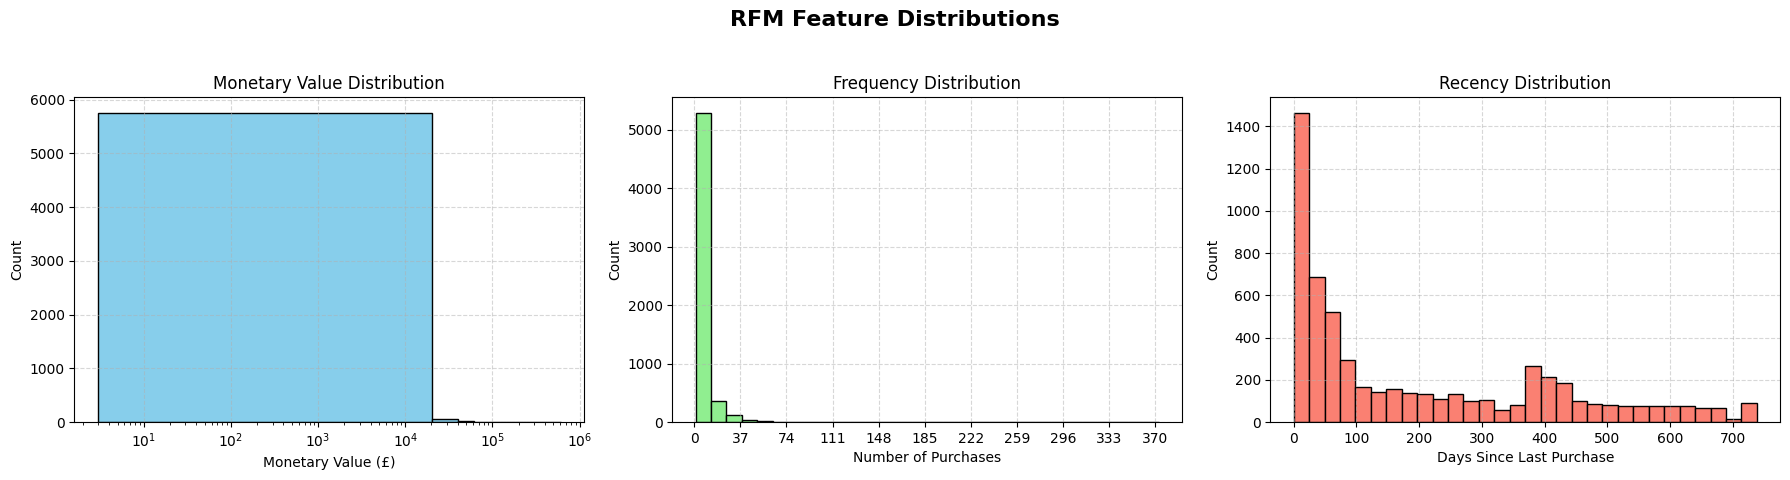

In [15]:
import matplotlib.ticker as mtick

plt.figure(figsize=(18, 5))

# Monetary Value - use log scale for better visibility if distribution is skewed
plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=30, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value (£)')
plt.ylabel('Count')
plt.xscale('log')  # Log scale to handle skewness
plt.grid(True, linestyle='--', alpha=0.5)

# Frequency - integer ticks only
plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Count')
plt.xticks(range(0, aggregated_df['Frequency'].max() + 1, max(1, aggregated_df['Frequency'].max() // 10)))
plt.grid(True, linestyle='--', alpha=0.5)

# Recency - days since last purchase
plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=30, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('RFM Feature Distributions', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

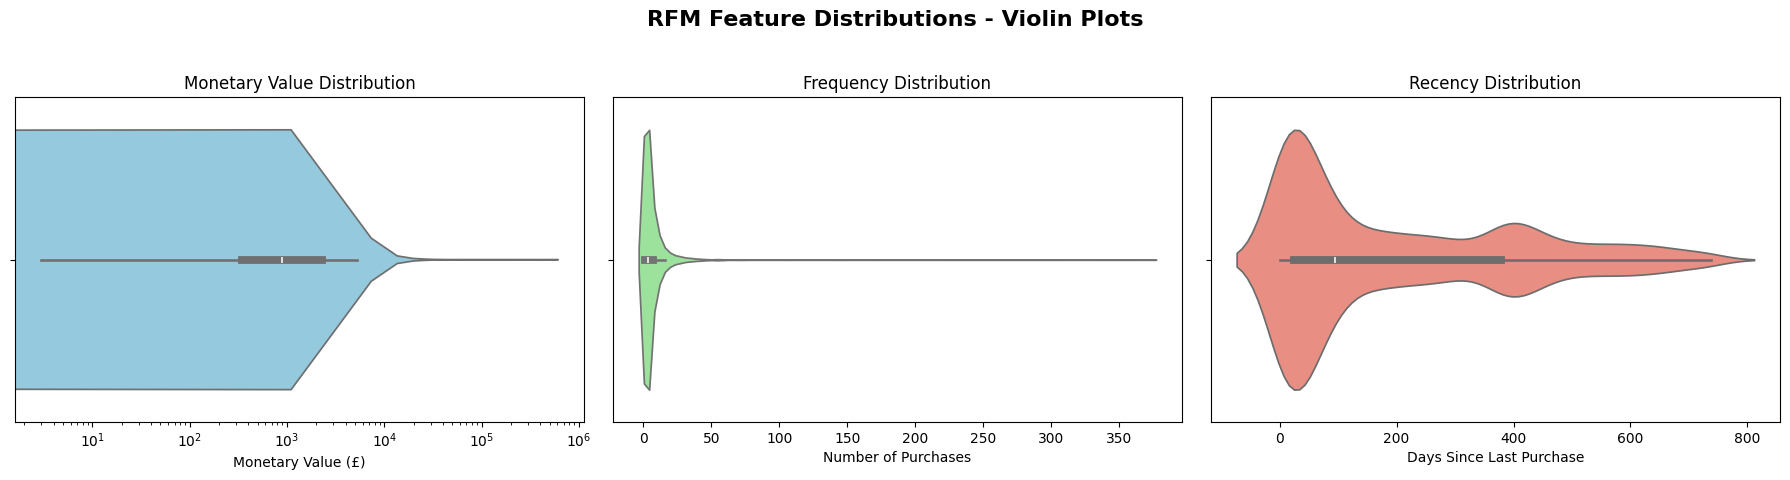

In [16]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.violinplot(x=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value (£)')
plt.xscale('log')  # Optional: log scale to manage skewness

plt.subplot(1, 3, 2)
sns.violinplot(x=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')

plt.subplot(1, 3, 3)
sns.violinplot(x=aggregated_df['Recency'], color='salmon')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')

plt.suptitle('RFM Feature Distributions - Violin Plots', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
# --- Outliers in Monetary Value ---
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

# Filter rows where MonetaryValue is an outlier based on 1.5 * IQR rule
monetary_outliers_df = aggregated_df[
    (aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) |
    (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))
].copy()

monetary_outliers_df.describe()

# --- Outliers in Frequency ---
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

# Filter Frequency outliers based on IQR rule
frequency_outliers_df = aggregated_df[
    (aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) |
    (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))
].copy()

frequency_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,Recency
count,424.00,424.00,424.00,424.00
mean,"15,373.75","21,143.85",34.87,30.79
std,"1,777.62","49,369.50",34.68,70.63
min,"12,415.00","1,820.44",17.00,0.00
25%,"13,851.00","6,368.09",20.00,2.75
50%,"15,306.00","9,760.71",25.00,9.00
75%,"16,947.25","16,691.30",35.00,24.00
max,"18,283.00","608,821.65",373.00,575.00


In [18]:
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) &
    (~aggregated_df.index.isin(frequency_outliers_df.index))
]

non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,Recency
count,"5,167.00","5,167.00","5,167.00","5,167.00"
mean,"15,341.72","1,133.52",3.69,218.90
std,"1,705.11","1,128.97",3.19,211.12
min,"12,348.00",2.95,1.00,0.00
25%,"13,862.50",311.03,1.00,32.00
50%,"15,355.00",717.51,3.00,133.00
75%,"16,811.50","1,579.13",5.00,392.00
max,"18,287.00","5,202.97",16.00,738.00


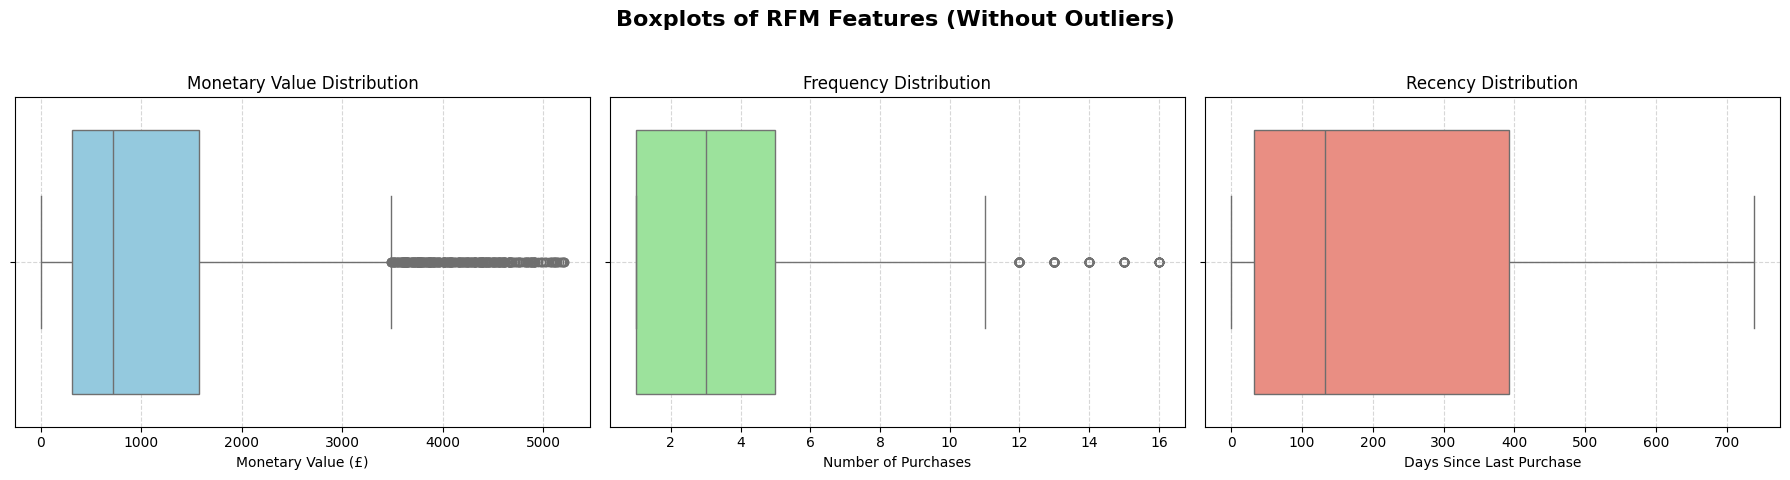

In [19]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value (£)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 3, 2)
sns.boxplot(x=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 3, 3)
sns.boxplot(x=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Boxplots of RFM Features (Without Outliers)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


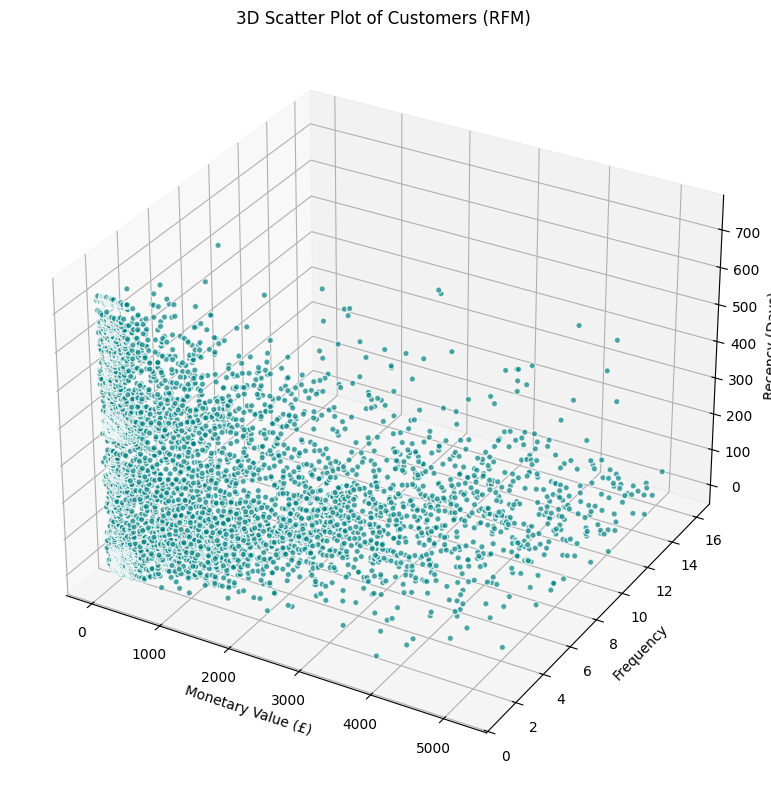

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting (sometimes implicit)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    non_outliers_df["MonetaryValue"], 
    non_outliers_df["Frequency"], 
    non_outliers_df["Recency"],
    c='teal', edgecolor='w', alpha=0.7
)

ax.set_xlabel('Monetary Value (£)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency (Days)')
ax.set_title('3D Scatter Plot of Customers (RFM)')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on RFM features and transform to scaled numeric data
scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

# Convert scaled array back into a DataFrame with original customer index
scaled_data_df = pd.DataFrame(
    scaled_data,
    index=non_outliers_df.index,
    columns=["MonetaryValue", "Frequency", "Recency"]
)

scaled_data_df.head()

,MonetaryValue,Frequency,Recency
2,0.46,0.41,-0.69
3,2.25,-0.22,-0.95
4,-0.74,-0.84,0.43
5,-0.74,-0.84,0.73
6,0.53,1.66,-0.87


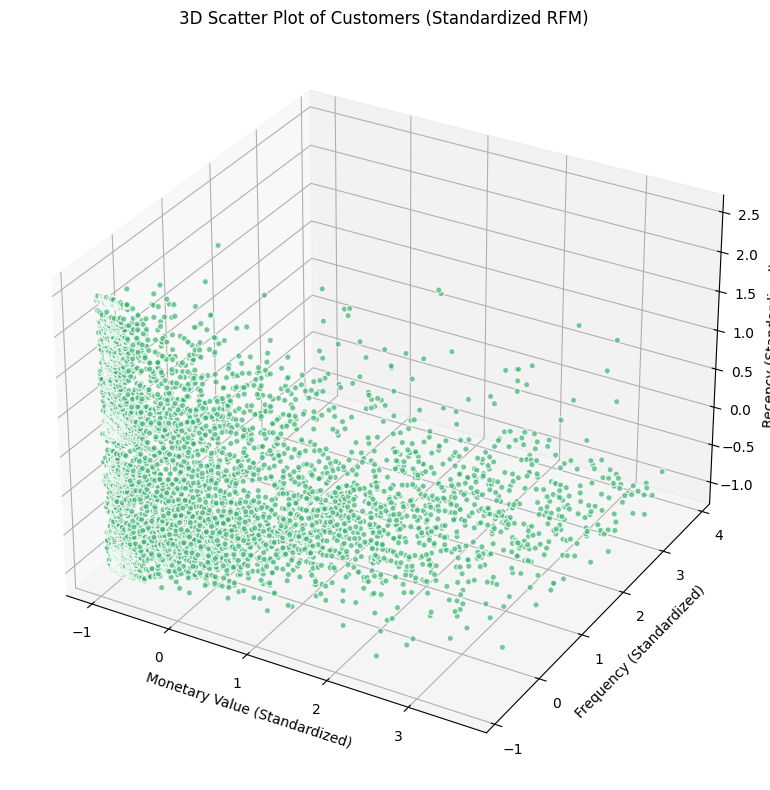

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter of scaled data
scatter = ax.scatter(
    scaled_data_df["MonetaryValue"],
    scaled_data_df["Frequency"],
    scaled_data_df["Recency"],
    color='mediumseagreen',
    alpha=0.7,
    edgecolor='w'
)

ax.set_xlabel('Monetary Value (Standardized)')
ax.set_ylabel('Frequency (Standardized)')
ax.set_zlabel('Recency (Standardized)')
ax.set_title('3D Scatter Plot of Customers (Standardized RFM)')

plt.tight_layout()
plt.show()


c:\Users\KNPRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\KNPRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\KNPRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\KNPRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

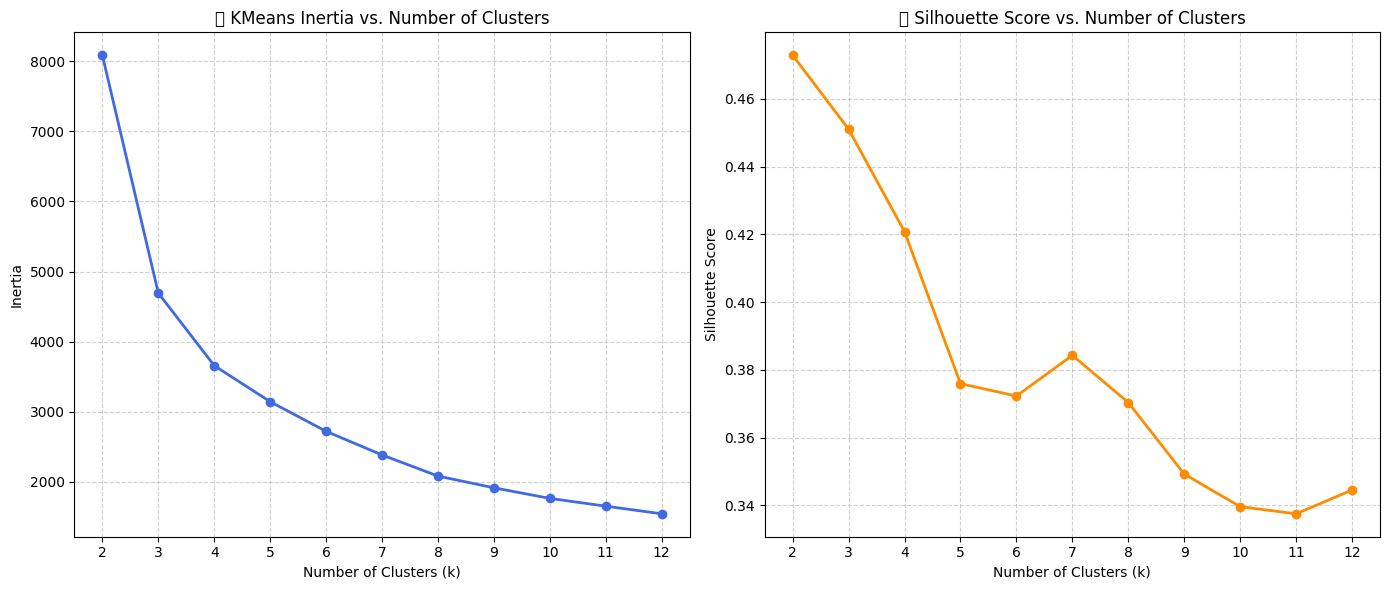

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_k = 12
k_values = range(2, max_k + 1)

inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data_df, cluster_labels))

# Plotting results
plt.figure(figsize=(14, 6))

# Elbow plot (Inertia)
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', color='royalblue', linewidth=2)
plt.title('📉 KMeans Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.6)

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='darkorange', linewidth=2)
plt.title('🧭 Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [25]:
from sklearn.cluster import KMeans

# Fit KMeans with chosen number of clusters
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

# Get cluster labels for each customer
cluster_labels = kmeans.fit_predict(scaled_data_df)

# Assign cluster labels without triggering SettingWithCopyWarning
non_outliers_df = non_outliers_df.copy()
non_outliers_df["Cluster"] = cluster_labels

# Preview dataset with assigned cluster labels
non_outliers_df.head()

c:\Users\KNPRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
2,"12,348.00","1,658.40",5,2011-09-25 13:13:00,74,3
3,"12,349.00","3,678.69",3,2011-11-21 09:51:00,18,3
4,"12,350.00",294.40,1,2011-02-02 16:01:00,309,2
5,"12,351.00",300.93,1,2010-11-29 15:23:00,374,2
6,"12,352.00","1,729.54",9,2011-11-03 14:37:00,35,3


C:\Users\KNPRO\AppData\Local\Temp\ipykernel_22084\1931694087.py:31: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KNPRO\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


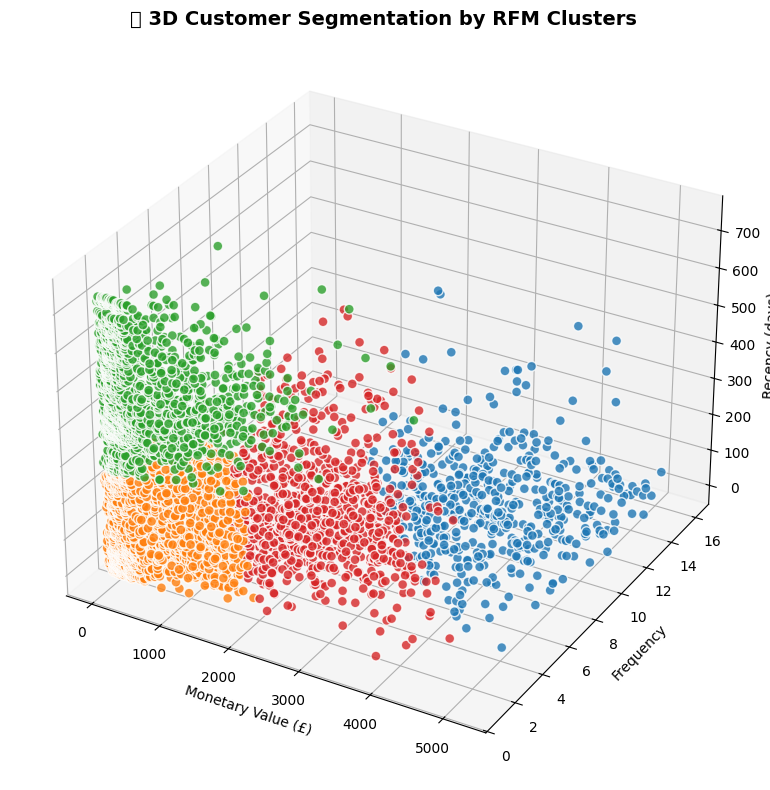

In [28]:
# Define custom colors for each cluster
cluster_colors = {
    0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728'   # Red
}

# Map cluster labels to colors
colors = non_outliers_df['Cluster'].map(cluster_colors)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    non_outliers_df['MonetaryValue'],
    non_outliers_df['Frequency'],
    non_outliers_df['Recency'],
    c=colors,
    s=50,
    alpha=0.8,
    edgecolor='w'
)

ax.set_xlabel('Monetary Value (£)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_zlabel('Recency (days)', fontsize=10)
ax.set_title('🎯 3D Customer Segmentation by RFM Clusters', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

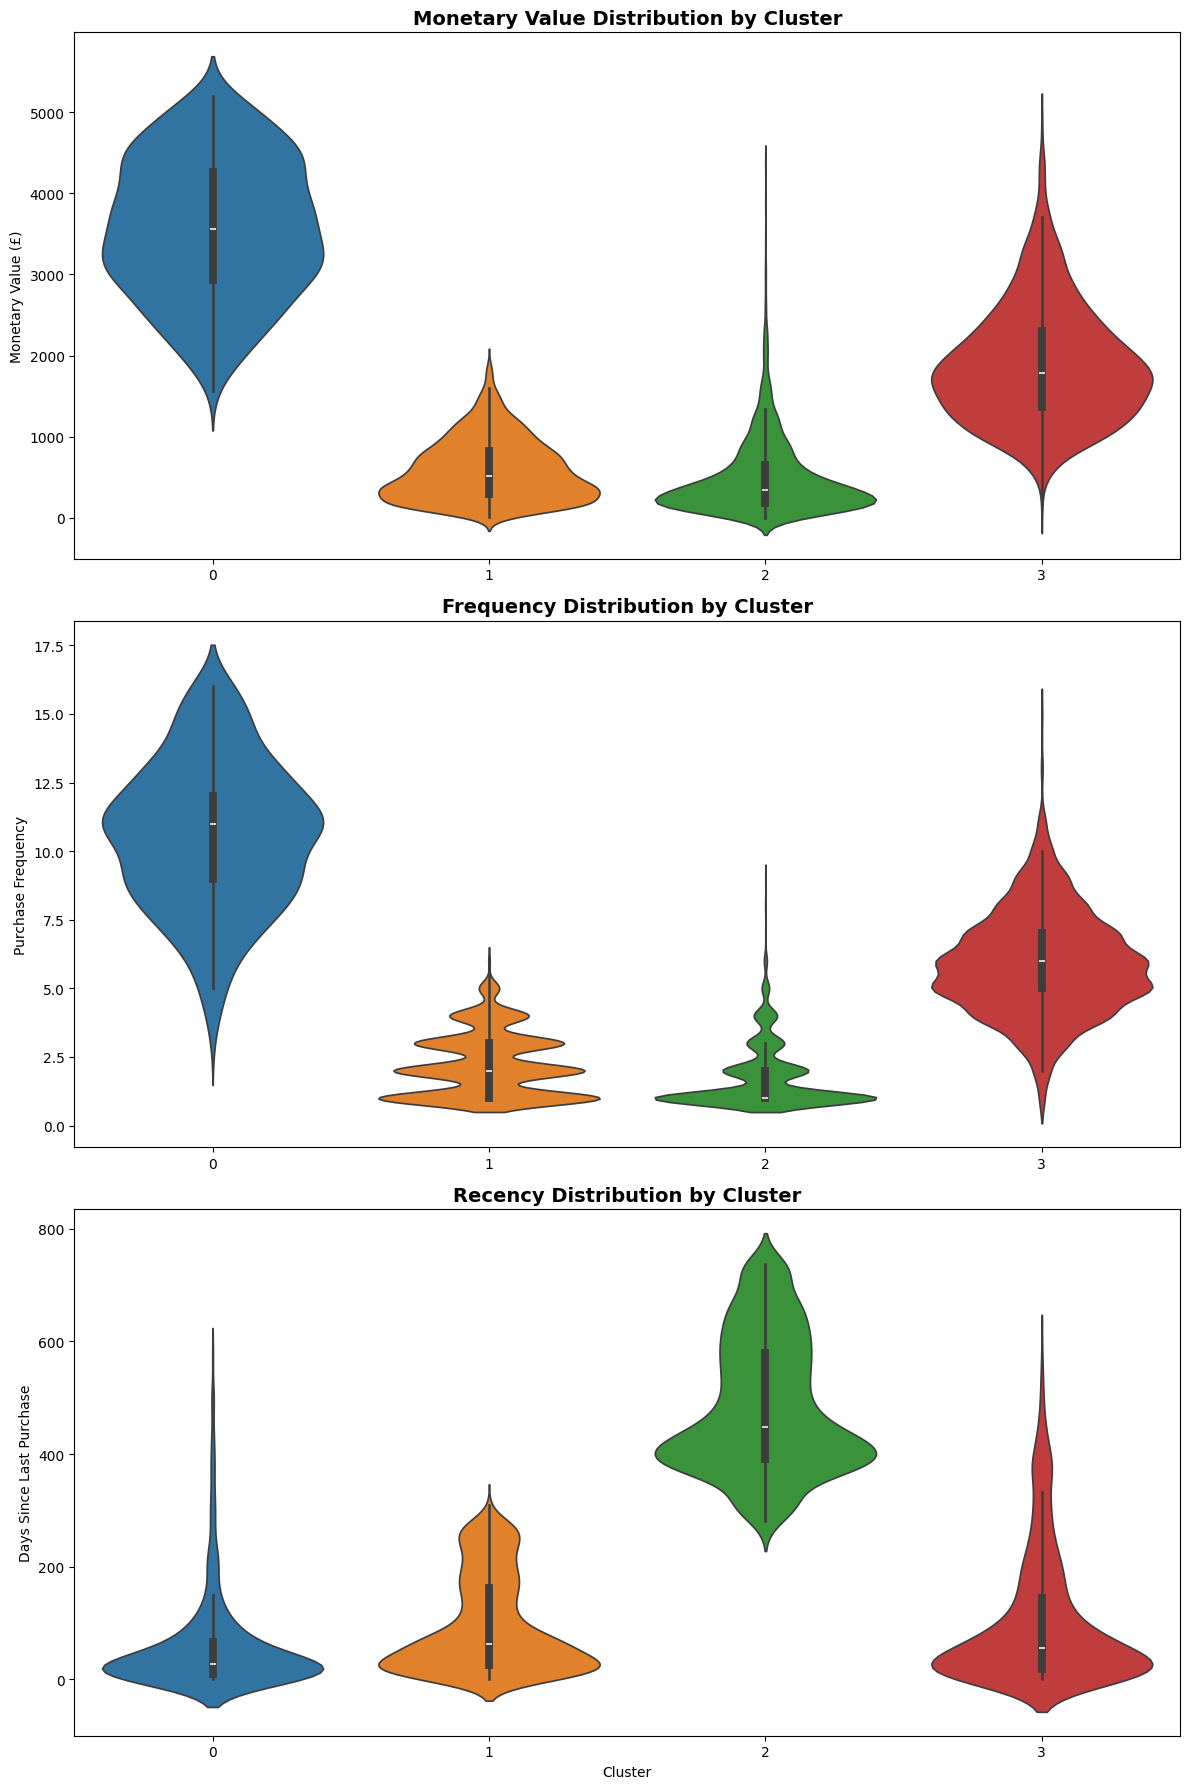

In [31]:
plt.figure(figsize=(12, 18))

# Monetary Value by Cluster
plt.subplot(3, 1, 1)
sns.violinplot(x='Cluster', y='MonetaryValue', data=non_outliers_df, palette=cluster_colors,hue="Cluster",legend=False)
plt.title('Monetary Value Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Monetary Value (£)')

# Frequency by Cluster
plt.subplot(3, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=non_outliers_df, palette=cluster_colors,hue="Cluster",legend=False)
plt.title('Frequency Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Purchase Frequency')

# Recency by Cluster
plt.subplot(3, 1, 3)
sns.violinplot(x='Cluster', y='Recency', data=non_outliers_df, palette=cluster_colors,hue="Cluster",legend=False)
plt.title('Recency Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Days Since Last Purchase')

plt.tight_layout()
plt.show()


In [32]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

# Separate outlier groups
monetary_only_outliers = monetary_outliers_df.drop(overlap_indices).copy()
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices).copy()
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices].copy()

# Assign cluster labels
monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

# Combine all outliers
outlier_clusters_df = pd.concat([
    monetary_only_outliers,
    frequency_only_outliers,
    monetary_and_frequency_outliers
])

outlier_clusters_df.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,"12,346.00","77,352.96",3,2011-01-18 10:01:00,325,-1
1,"12,347.00","5,633.32",8,2011-12-07 15:52:00,1,-1
10,"12,356.00","5,613.68",6,2011-11-17 08:40:00,22,-1
11,"12,357.00","17,437.66",2,2011-11-06 16:07:00,32,-1
13,"12,359.00","8,935.94",10,2011-10-13 12:47:00,57,-1


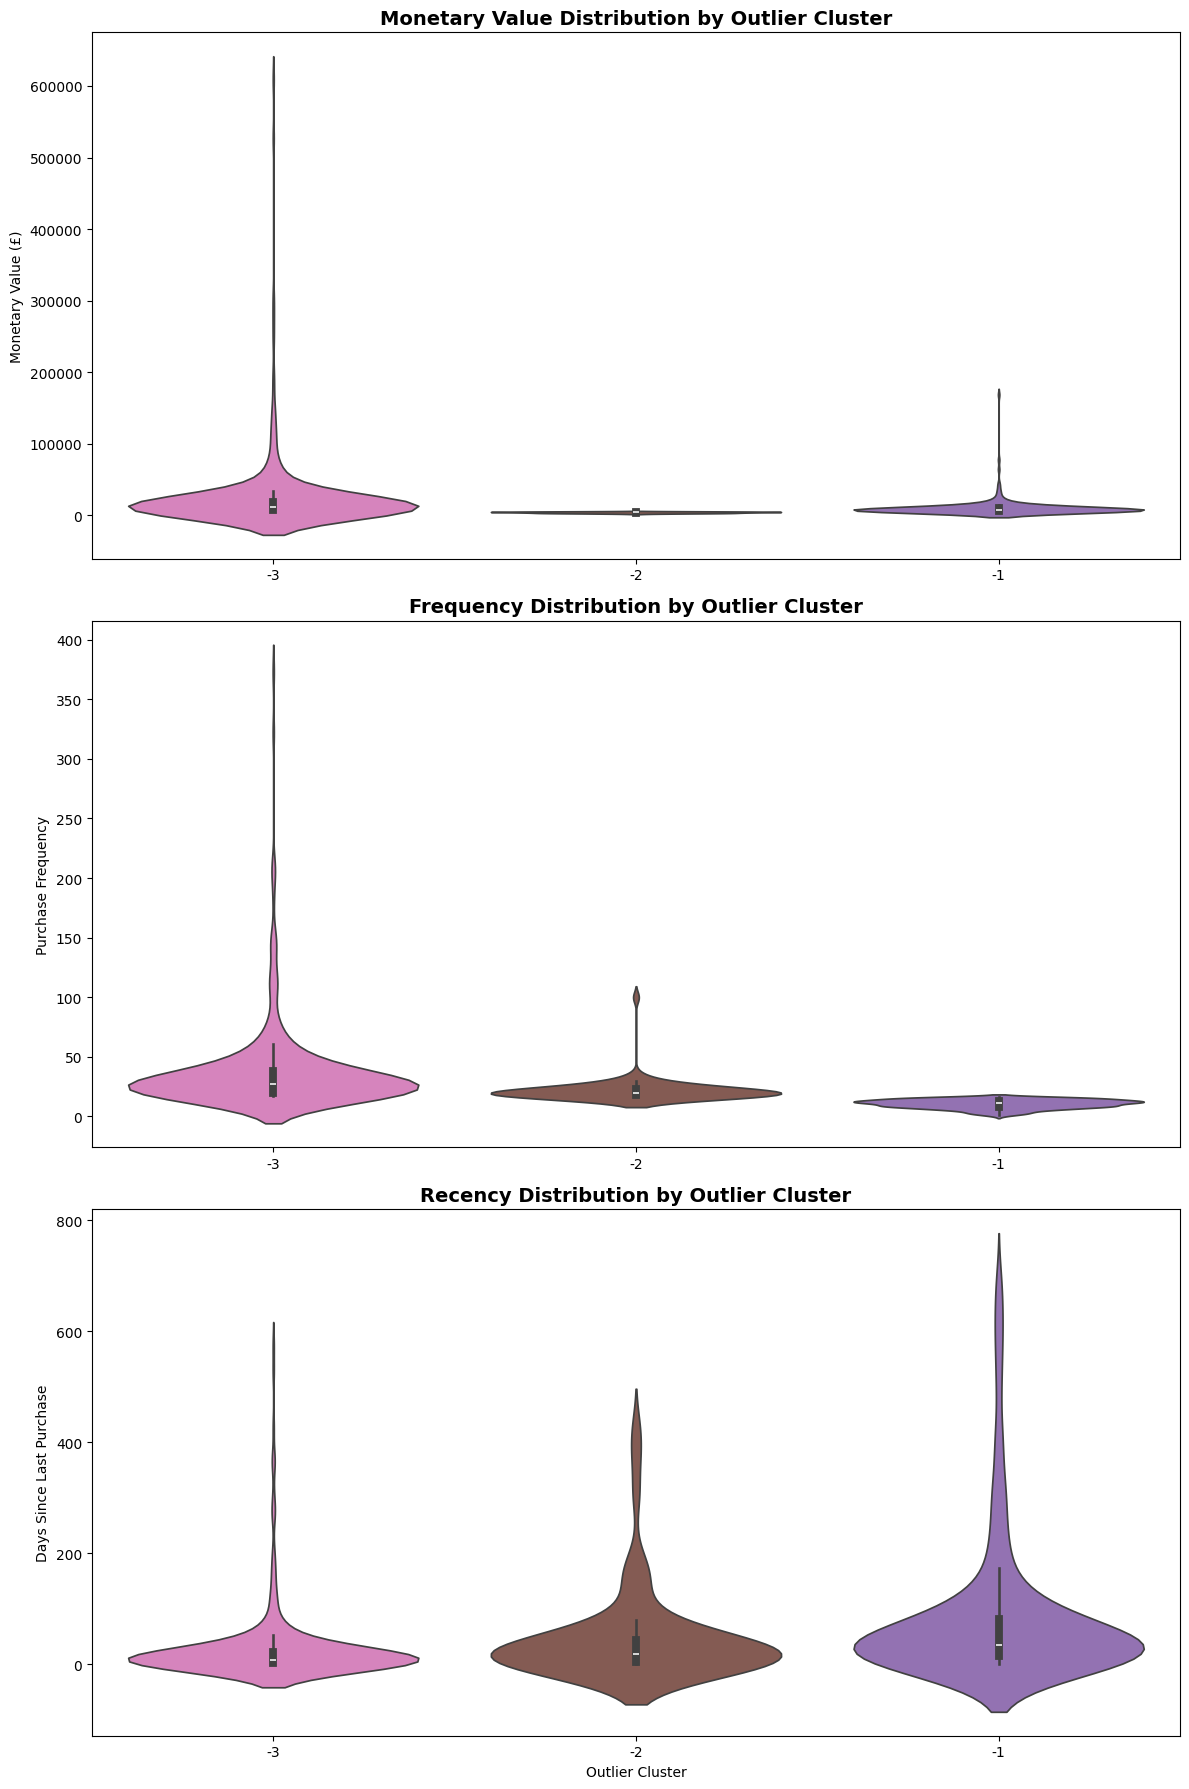

In [34]:
cluster_colors = {
    -1: '#9467bd',   # Purple - Monetary only
    -2: '#8c564b',   # Brown - Frequency only
    -3: '#e377c2'    # Pink - Both
}

plt.figure(figsize=(12, 18))

# Monetary Value
plt.subplot(3, 1, 1)
sns.violinplot(x='Cluster', y='MonetaryValue', data=outlier_clusters_df, palette=cluster_colors,hue="Cluster",legend=False)
plt.title('Monetary Value Distribution by Outlier Cluster', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Monetary Value (£)')

# Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=outlier_clusters_df, palette=cluster_colors,hue="Cluster",legend=False)
plt.title('Frequency Distribution by Outlier Cluster', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Purchase Frequency')

# Recency
plt.subplot(3, 1, 3)
sns.violinplot(x='Cluster', y='Recency', data=outlier_clusters_df, palette=cluster_colors,hue="Cluster",legend=False)
plt.title('Recency Distribution by Outlier Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Outlier Cluster')
plt.ylabel('Days Since Last Purchase')

plt.tight_layout()
plt.show()

In [35]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

# Combine main and outlier clusters into one DataFrame
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

# Make a safe copy and map labels
full_clustering_df = full_clustering_df.copy()
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)


# Preview final segmentation
full_clustering_df.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
2,"12,348.00","1,658.40",5,2011-09-25 13:13:00,74,3,REWARD
3,"12,349.00","3,678.69",3,2011-11-21 09:51:00,18,3,REWARD
4,"12,350.00",294.40,1,2011-02-02 16:01:00,309,2,NURTURE
5,"12,351.00",300.93,1,2010-11-29 15:23:00,374,2,NURTURE
6,"12,352.00","1,729.54",9,2011-11-03 14:37:00,35,3,REWARD


C:\Users\KNPRO\AppData\Local\Temp\ipykernel_22084\2088747090.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis')


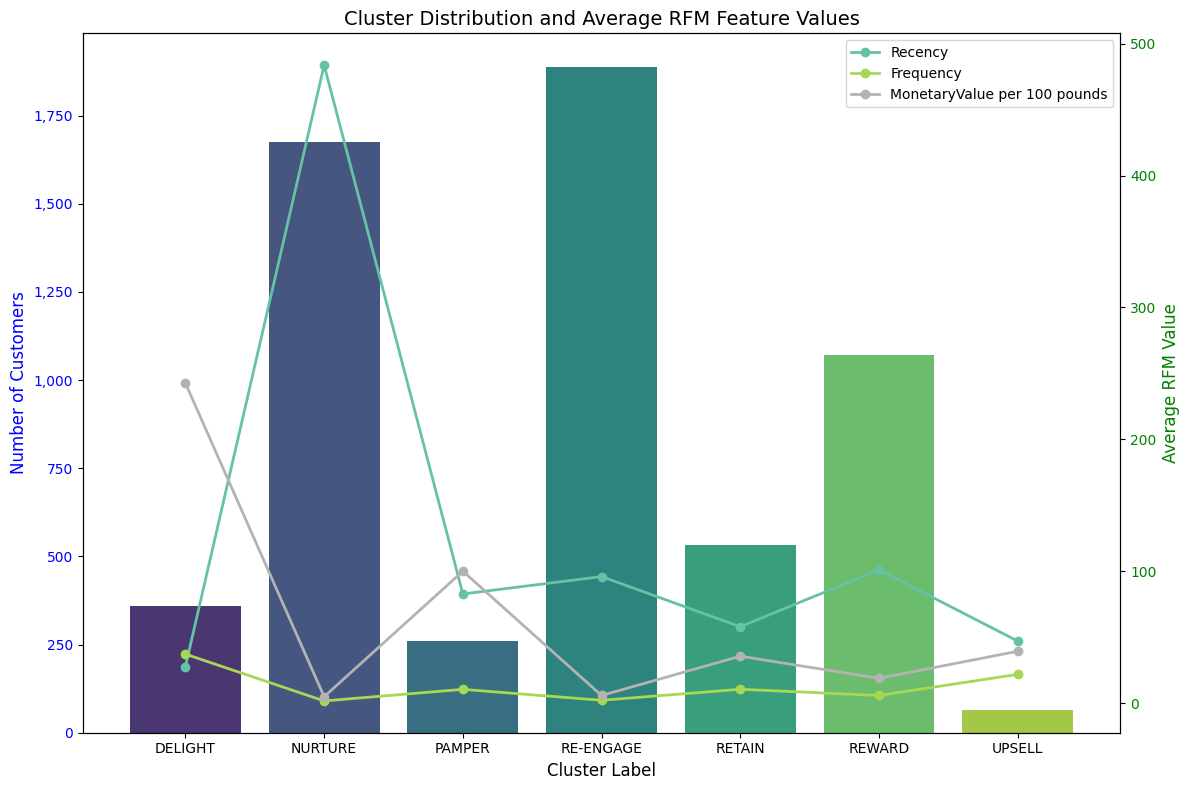

In [36]:
import matplotlib.ticker as ticker

# Calculate counts and averages
cluster_counts = full_clustering_df['ClusterLabel'].value_counts().sort_index()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.0
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean().sort_index()

fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot of cluster sizes
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis')
ax1.set_ylabel('Number of Customers', color='b', fontsize=12)
ax1.set_xlabel('Cluster Label', fontsize=12)
ax1.set_title('Cluster Distribution and Average RFM Feature Values', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Line plot of average RFM features
ax2 = ax1.twinx()
feature_means.plot(
    kind='line',
    ax=ax2,
    marker='o',
    linewidth=2,
    colormap='Set2',
    legend=True
)
ax2.set_ylabel('Average RFM Value', color='g', fontsize=12)
ax2.tick_params(axis='y', labelcolor='g')

plt.tight_layout()
plt.show()

In [37]:
import plotly.express as px

cluster_colors = {
    0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728'   # Red
}

fig = px.scatter_3d(
    non_outliers_df,
    x='MonetaryValue',
    y='Frequency',
    z='Recency',
    color='Cluster',  # Use cluster labels, not colors
    color_discrete_map=cluster_colors,
    title='3D Scatter Plot of Customer Data by Cluster',
    labels={'MonetaryValue': 'Monetary Value', 'Frequency': 'Frequency', 'Recency': 'Recency'},
    hover_name='Cluster',
    hover_data={'MonetaryValue': True, 'Frequency': True, 'Recency': True}
)

fig.update_traces(marker=dict(size=5))

fig.update_layout(
    scene=dict(
        xaxis_title='Monetary Value',
        yaxis_title='Frequency',
        zaxis_title='Recency'
    ),
    margin=dict(l=0, r=0, b=0, t=30),
    showlegend=True
)

fig.show()